In [6]:
import json
import numpy as np
from tqdm import tqdm
from dataclasses import asdict
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
import shapely
import shapely.wkt
from shapely.geometry import Polygon, MultiPolygon
# sys.path.append("/home/weedsci/matt/SemiF-AnnotationPipeline")
# os.chdir("/home/weedsci/matt/SemiF-SyntheticPipeline/")
sys.path.append("/home/psa_images/SemiF-AnnotationPipeline/")
sys.path.append("/home/mkutuga/SemiF-SyntheticPipeline/utils")
from semif_utils.datasets import Cutout
from synth_utils.config_utils import cutoutmeta2csv, get_cutout_meta
from synth_utils.viz import plot_cutouts
from datetime import date

today = date.today().strftime("%Y-%m-%d")

/home/mkutuga/anaconda3/envs/semif/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ModuleNotFoundError: No module named 'utils.utils'; 'utils' is not a package

#### Cutout2metacsv

In [2]:
# path = "/home/weedsci/matt/SemiF-AnnotationPipeline/data/semifield-cutouts/MD_2022-07-05/MD_Row-10_1657032952_6.json"
cutoutdir = "/home/weedsci/matt/SemiF-AnnotationPipeline/data/semifield-cutouts"
# batch_id = "MD_2022-07-06_v1_unfinished"
savedir = "/home/weedsci/matt/SemiF-AnnotationPipeline/Assets"
# batchdir = "/home/weedsci/matt/SemiF-AnnotationPipeline/data/semifield-cutouts"
batchdir = "/media/hdd1/mkutu/wir/semifield-cutouts"

# Get batches without csvs already made
batch_ids = sorted([
    x.name for x in Path(batchdir).glob("*")
    if ("." not in x.name) & (not Path(x, x.name + ".csv").is_file())
])
# metajsons = sorted(Path(batchdir).rglob("*.json"))
batch_ids

[]

## Create Cutout CSVs

In [6]:
dfs = []
for batch_id in batch_ids:
    csv_path = f"{batchdir}/{batch_id}/{batch_id}.csv"
    save_path = f"{savedir}/{batch_id}_histogram.png"

    df = cutoutmeta2csv(cutoutdir, batch_id, csv_path, save_df=True)


100%|██████████| 2801/2801 [00:03<00:00, 852.08it/s]


### Dataframe for all Cutouts so far

In [3]:
# Get all cutouts
batchdir = "/home/weedsci/matt/SemiF-AnnotationPipeline/data/semifield-cutouts"
cutout_dfs = [pd.read_csv(x) for x in Path(batchdir).rglob("*.csv")]
allcuts = pd.concat(cutout_dfs).reset_index(drop=True)
allcuts = allcuts[allcuts["common_name"] != "unknown"]
allcuts


,blob_home,data_root,batch_id,image_id,cutout_num,datetime,dap,cutout_id,cutout_path,is_primary,...,axis_minor_length,centroid0,centroid1,eccentricity,extent,solidity,perimeter,is_green,green_sum,synth
0,data,semifield-cutouts,MD_2022-08-24,MD_1661346765,0,2022:08:24 21:09:03,26,MD_1661346765_0,MD_2022-08-24/MD_1661346765_0.png,True,...,1429.330101,9585.666448,17147.676237,7.060039,6.308763,8.394719,22969.729568,True,574584,NaN
1,data,semifield-cutouts,MD_2022-08-24,MD_1661346765,1,2022:08:24 21:09:03,26,MD_1661346765_1,MD_2022-08-24/MD_1661346765_1.png,False,...,408.702778,237.803063,521.387678,0.875798,0.138863,0.275796,3553.473626,True,29027,NaN
2,data,semifield-cutouts,MD_2022-08-24,MD_1661346765,2,2022:08:24 21:09:03,26,MD_1661346765_2,MD_2022-08-24/MD_1661346765_2.png,True,...,896.118052,2716.921855,6615.386236,5.062125,3.267720,4.734238,12424.701146,True,160892,NaN
3,data,semifield-cutouts,MD_2022-08-24,MD_1661346765,3,2022:08:24 21:09:03,26,MD_1661346765_3,MD_2022-08-24/MD_1661346765_3.png,False,...,1337.852990,11663.321572,8020.537146,7.499073,4.984074,6.750127,20895.640390,True,585330,NaN
4,data,semifield-cutouts,MD_2022-08-24,MD_1661346765,4,2022:08:24 21:09:03,26,MD_1661346765_4,MD_2022-08-24/MD_1661346765_4.png,False,...,34.705179,82.112921,51.497434,0.983657,0.244489,0.783940,449.250829,True,1009,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115419,data,semifield-cutouts,MD_2022-08-04,MD_1659626726,6,2022:08:04 23:22:05,6,MD_1659626726_6,MD_2022-08-04/MD_1659626726_6.png,True,...,172.440632,144.898045,231.574006,0.912145,0.379208,0.725658,1124.832611,True,32002,NaN
115420,data,semifield-cutouts,MD_2022-08-04,MD_1659626726,7,2022:08:04 23:22:05,6,MD_1659626726_7,MD_2022-08-04/MD_1659626726_7.png,False,...,149.545163,277.886963,127.568115,0.951245,0.488236,0.795346,1192.354473,True,38989,NaN
115421,data,semifield-cutouts,MD_2022-08-04,MD_1659626726,8,2022:08:04 23:22:05,6,MD_1659626726_8,MD_2022-08-04/MD_1659626726_8.png,False,...,206.144437,170.763486,233.590688,0.904442,0.354406,0.663583,1319.844805,True,35176,NaN
115422,data,semifield-cutouts,MD_2022-08-04,MD_1659626726,9,2022:08:04 23:22:05,6,MD_1659626726_9,MD_2022-08-04/MD_1659626726_9.png,False,...,169.252979,147.467896,260.209071,0.933033,0.450215,0.748116,1222.094588,True,36541,NaN


In [14]:
allcuts[
    "temp_path"] = "/home/weedsci/matt/SemiF-AnnotationPipeline/data/semifield-cutouts" + allcuts[
        "cutout_path"]
allcuts["temp_path"].shape

(115354,)

### View Cutouts

In [1]:
import shutil
from pathlib import Path

from omegaconf import DictConfig

from synth_utils.config_utils import read_cutouts, sort_cutouts


def main(cfg: DictConfig) -> None:
    """ Creates csv file with all configs to pul from based on cutout config yaml."""
    # Using species proportions
    if cfg.cutouts.mode == "species":
        alldf = read_cutouts(cfg.data.cutoutdir)
        df = sort_cutouts(alldf, cfg, save_csv=True)

ModuleNotFoundError: No module named 'synth_utils'

NameError: name 'df' is not defined

## Plot Cutouts per batch and all together

### By batch

In [5]:
from tqdm import tqdm
for batch in tqdm(allcuts.batch_id.unique()):
    bdf = allcuts[allcuts["batch_id"] == batch]
    plot_cutouts(subplot=1,
                 df=bdf,
                 y='common_name',
                 title=batch,
                 figsize=(12, 8),
                 color="RdYlGn",
                 xlabel="Number of cutouts",
                 ylabel='',
                 rotation=0,
                 tick_bottom=True,
                 tick_left=True,
                 text_wrapping=13,
                 save_path=f"{savedir}/{batch}_histogram.png",
                 save=True,
                 show=False)


### All cutouts

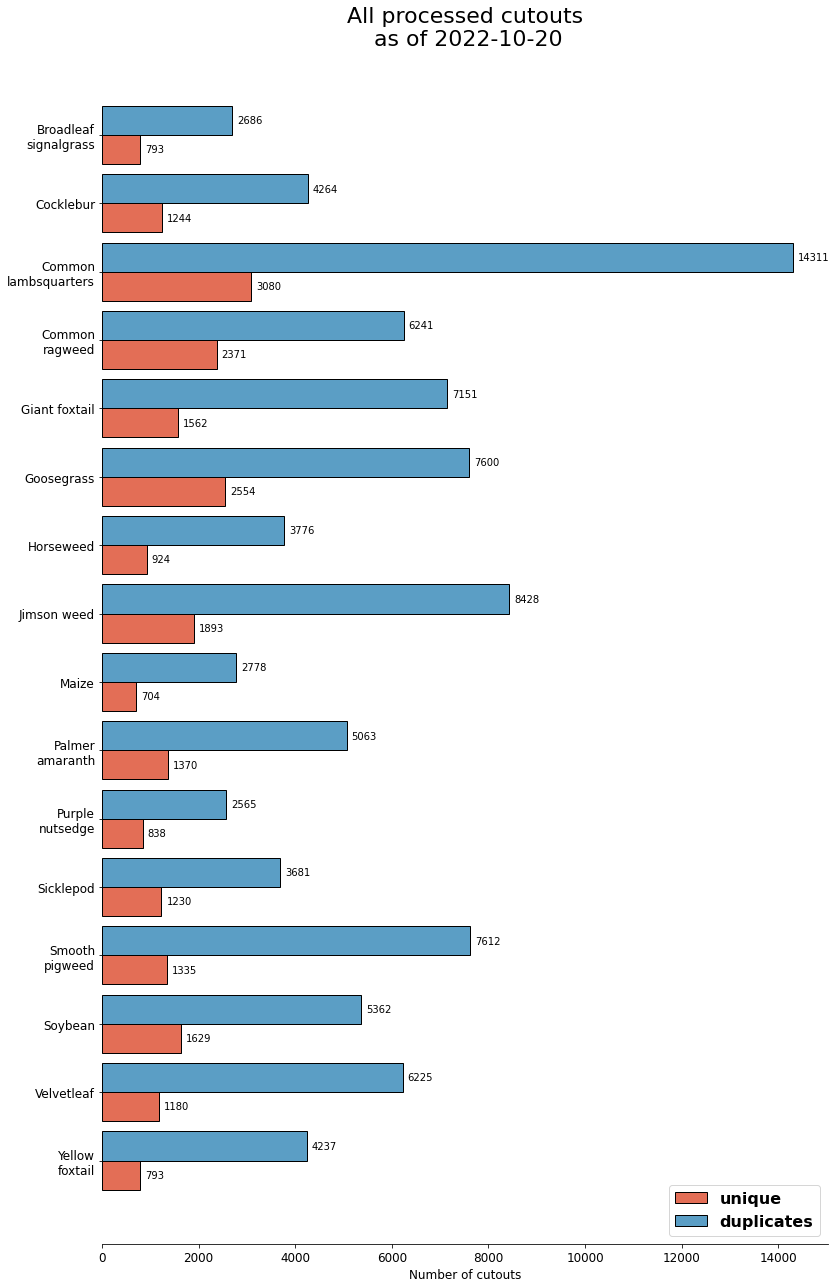

In [11]:
plot_cutouts(subplot=1,
             df=allcuts,
             y='common_name',
             title=f"All processed cutouts\n as of {today}",
             figsize=(22, 18),
             color="viridis",
             xlabel="Number of cutouts",
             ylabel='',
             rotation=0,
             tick_bottom=True,
             tick_left=True,
             text_wrapping=13,
             save_path=f"{savedir}/ALL_cutout_figure.png",
             save=False,
             show=True)


In [18]:
len(allcuts.batch_id.unique())

28

### Summary Statistics

In [12]:
print("Number of Images: ", allcuts["image_id"].nunique())
print(
    "Sum Unique(primary) Cutouts: ",
    sum(allcuts[allcuts["is_primary"] == True].groupby(
        ["common_name"])["image_id"].value_counts()))
print("Total Number of Cutouts: ",
      sum(allcuts.groupby(["common_name"])["cutout_id"].value_counts()))
print()
print("Number of Unique Cutouts:\n",
      allcuts[allcuts["is_primary"] == True].common_name.value_counts())
allcuts.columns


Number of Images:  12384
Sum Unique(primary) Cutouts:  23500
Total Number of Cutouts:  115480

Number of Unique Cutouts:
 Common lambsquarters     3080
Goosegrass               2554
Common ragweed           2371
Jimson weed              1893
Soybean                  1629
Giant foxtail            1562
Palmer amaranth          1370
Smooth pigweed           1335
Cocklebur                1244
Sicklepod                1230
Velvetleaf               1180
Horseweed                 924
Purple nutsedge           838
Yellow foxtail            793
Broadleaf signalgrass     793
Maize                     704
Name: common_name, dtype: int64


Index(['blob_home', 'data_root', 'batch_id', 'image_id', 'cutout_num',
       'datetime', 'dap', 'cutout_id', 'cutout_path', 'is_primary',
       'extends_border', 'cutout_version', 'schema_version', 'area',
       'scientific_name', 'common_name', 'USDA_symbol', 'EPPO', 'authority',
       'collection_location', 'polygon_id', 'class_id', 'hex', 'r', 'g', 'b',
       'area_bbox', 'area_convex', 'axis_major_length', 'axis_minor_length',
       'centroid0', 'centroid1', 'eccentricity', 'extent', 'solidity',
       'perimeter', 'is_green', 'green_sum', 'synth'],
      dtype='object')

In [20]:
sum_unique = sum(allcuts[allcuts["is_primary"] == True].groupby(
    ["common_name"])["image_id"].value_counts())
sum_all = sum(allcuts.groupby(["common_name"])["cutout_id"].value_counts())
costs = {
    "aws sagemaker": {
        "tiers": {
            "tier 1": {
                "units": 1,
                "bbox": 0.036,
                "semantic": 0.84
            }
        },
        "time": {}
    },
    "google cloud": {
        "tiers": {
            "tier 1": {
                "units": 1000,
                "bbox": 63,
                "semantic": 870
            },
            "tier 2": {
                "units": 1000,
                "bbox": 49,
                "semantic": 850
            }
        },
        "time": {}
    },
    "BWI Solutions": {
        "tiers": {
            "tier 1": {
                "units": 1,
                "bbox": 0.085,
                "semantic": 0.125
            },
        },
        "time": {
            "weeks": 2.5,
            "segments": 11000
        },
    }

    # "V7": {
    #     "tiers": {
    #         "tier 1": {
    #             "units": 1,
    #             "bbox": 1,
    #             "semantic": 1
    #         }
    #     }
    # }
}

for company in costs:
    tiers = costs[company]["tiers"]
    time = costs[company]["time"]
    for tier_num in costs[company]["tiers"]:
        pricing = tiers[tier_num]
        units = pricing.get("units")
        print(f"\n{company}")
        print(tier_num)
        print("Units per tier: ", units)
        print("Cost of labeling all bboxes ",
              pricing.get("bbox") * sum_all / units)
        print("Cost of labeling unique bboxes ",
              pricing.get("bbox") * sum_unique / units)
        print("Cost of labeling all segments ",
              pricing.get("semantic") * sum_all / units)
        print("Cost of labeling unique segments ",
              pricing.get("semantic") * sum_unique / units)
        print("time", time)
        if time.get("weeks"):
            print("Estimated time: ")
            print("All cutouts (weeks): ",
                  time.get("weeks") * sum_all / time.get("segments"))
            print("Unique cutouts (weeks): ",
                  time.get("weeks") * sum_unique / time.get("segments"))



aws sagemaker
tier 1
Units per tier:  1
Cost of labeling all bboxes  4152.744
Cost of labeling unique bboxes  844.776
Cost of labeling all segments  96897.36
Cost of labeling unique segments  19711.44
time {}

google cloud
tier 1
Units per tier:  1000
Cost of labeling all bboxes  7267.302
Cost of labeling unique bboxes  1478.358
Cost of labeling all segments  100357.98
Cost of labeling unique segments  20415.42
time {}

google cloud
tier 2
Units per tier:  1000
Cost of labeling all bboxes  5652.346
Cost of labeling unique bboxes  1149.834
Cost of labeling all segments  98050.9
Cost of labeling unique segments  19946.1
time {}

BWI Solutions
tier 1
Units per tier:  1
Cost of labeling all bboxes  9805.09
Cost of labeling unique bboxes  1994.6100000000001
Cost of labeling all segments  14419.25
Cost of labeling unique segments  2933.25
time {'weeks': 2.5, 'segments': 11000}
Estimated time: 
All cutouts (weeks):  26.216818181818184
Unique cutouts (weeks):  5.333181818181818


## Plot Cutout Description

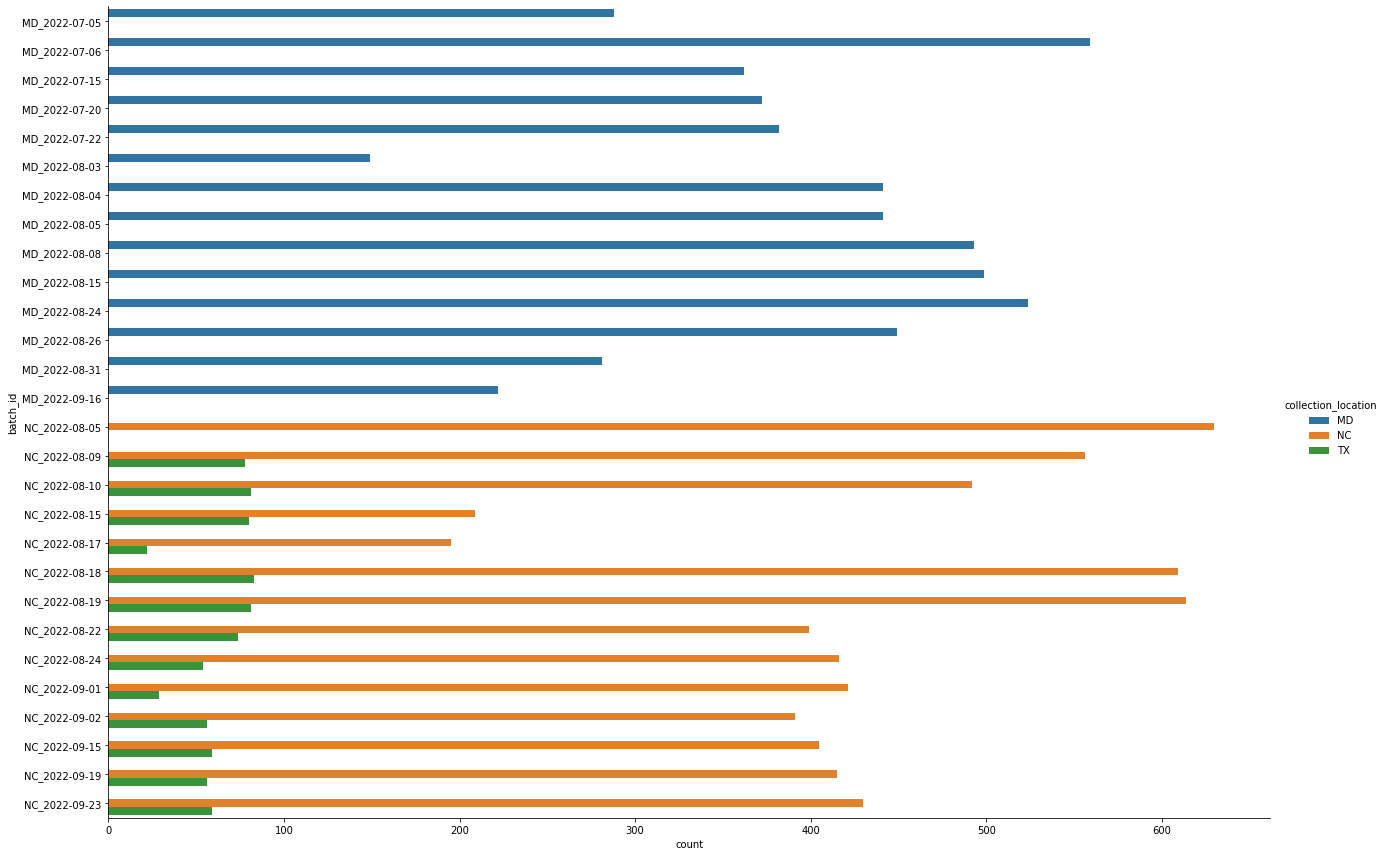

In [9]:
# data = pd.DataFrame(data={'val': values}, index=index).reset_index()

imgs = allcuts.groupby(["batch_id", "image_id",
                        "collection_location"]).nunique().reset_index()
# allcuts["image_id"].unique()
df = imgs.copy()
df.columns = df.columns.to_flat_index()
# df.columns = ['_'.join(x) for x in df.columns.get_level_values(0)]
# pprint(df.columns[20:])
df.head()
# imgs
df["collection_location"]
sns.catplot(data=df,
            y="batch_id",
            height=12,
            aspect=1.5,
            hue="collection_location",
            kind="count")
